![wordcloud](wordcloud.png)

As a Data Scientist working for a mobile app company, you usually find yourself applying product analytics to better understand user behavior, uncover patterns, and reveal insights to identify the great and not-so-great features. Recently, the number of negative reviews has increased on Google Play, and as a consequence, the app's rating has been decreasing. The team has requested you to analyze the situation and make sense of the negative reviews.

It's up to you to apply K-means clustering from scikit-learn and NLP techniques through NLTK to sort text data from negative reviews in the Google Play Store into categories!

## The Data

A dataset has been shared with a sample of reviews and their respective scores (from 1 to 5) in the Google Play Store. A summary and preview are provided below.

# reviews.csv

| Column     | Description              |
|------------|--------------------------|
| `'content'` | Content (text) of each review. |
| `'score'` | Score assigned to the review by the user as an integer (from 1 to 5). |

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Download necessary files from NLTK:
# punkt -> Tokenization
# stopwords -> Stop words removal
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Load the dataset
file_path = '/content/reviews.csv'
reviews_df = pd.read_csv(file_path)

In [7]:
# Filter negative reviews (score of 1 or 2)
negative_reviews = reviews_df[reviews_df['score'] <= 2]

In [8]:
# Preprocessing function
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove non-alphabetic characters and stop words
    stop_words = set(stopwords.words('english'))
    tokens = [re.sub(r'[^a-z]', '', token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

In [9]:
# Preprocess the reviews
negative_reviews['cleaned_content'] = negative_reviews['content'].apply(preprocess_text)


<ipython-input-9-12d3db6153e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['cleaned_content'] = negative_reviews['content'].apply(preprocess_text)


In [10]:
# Save the results in a DataFrame
preprocessed_reviews = negative_reviews[['content', 'cleaned_content', 'score']]

In [11]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_reviews['cleaned_content'])

In [12]:
# Apply K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
categories = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Add the cluster labels to the DataFrame
preprocessed_reviews['category'] = categories

<ipython-input-13-c9a7610b0663>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_reviews['category'] = categories


In [14]:

# Find the most frequent term in each cluster
terms = vectorizer.get_feature_names_out()
topic_terms = []

for i in range(num_clusters):
    cluster_indices = (preprocessed_reviews['category'] == i)
    cluster_reviews = tfidf_matrix[cluster_indices]
    centroid = kmeans.cluster_centers_[i]
    top_term_index = centroid.argsort()[-1]
    top_term = terms[top_term_index]
    term_frequency = cluster_reviews[:, top_term_index].sum()
    topic_terms.append([i, top_term, term_frequency])

In [15]:
# Store the results in a DataFrame
topic_terms_df = pd.DataFrame(topic_terms, columns=['Cluster Label', 'Top Term', 'Frequency'])


In [16]:
print(preprocessed_reviews)
print(topic_terms_df)

                                                 content  \
0                          I cannot open the app anymore   
1      I have been begging for a refund from this app...   
2      Very costly for the premium version (approx In...   
3      Used to keep me organized, but all the 2020 UP...   
4                                    Dan Birthday Oct 28   
...                                                  ...   
11940  I loved it until I realized that the very feat...   
11941  Gave it a test run and tried out the notificat...   
11942  Looks great but since installing, my device on...   
11943  This app looked good until I had to purchase i...   
11944                                           It's OK!   

                                         cleaned_content  score  category  
0                                       open app anymore      1         2  
1               begging refund app month nobody replying      1         2  
2      costly premium version approx indian rupees 

<ipython-input-17-f76cd6c75ff0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=preprocessed_reviews, palette='viridis')


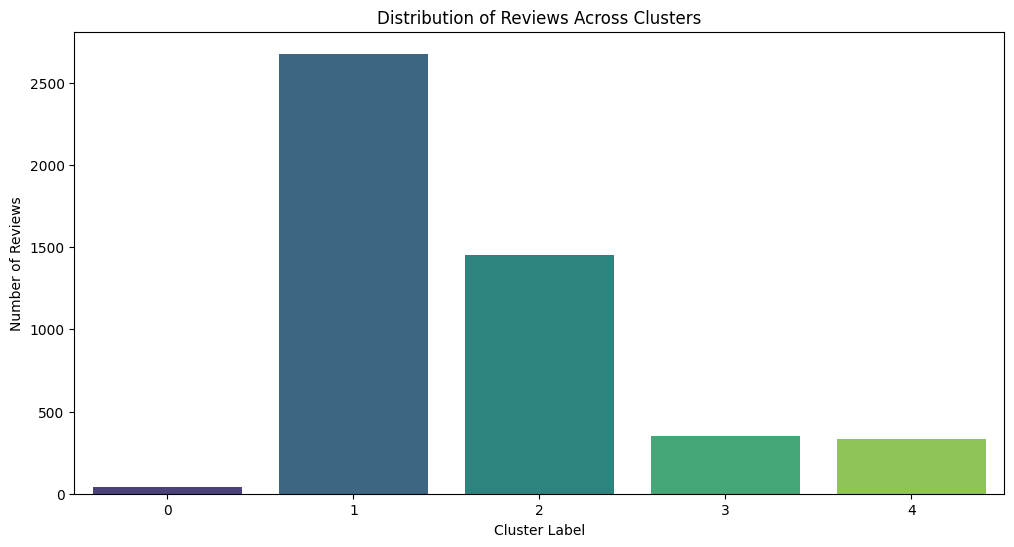

In [17]:
# Visualize the clusters
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=preprocessed_reviews, palette='viridis')
plt.title('Distribution of Reviews Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Visualize the top terms for each cluster
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster Label', y='Frequency', hue='Top Term', data=topic_terms_df, palette='viridis')
plt.title('Top Terms in Each Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency of Top Term')
plt.legend(title='Top Term', loc='upper right')
plt.show()